In [1]:
import numpy as np
import pandas as pd
#import xarray as xr
import matplotlib.pyplot as plt
import sys
import os
from utils import SHIPS_preprocess
from utils import SHIPS_ML_model_funcs
import seaborn as sns

### Model Parameters

##### SHIPS Dataset Choice
* `max_fore`: maximum forecast hours [usually 24 or 48]
* `mask_TYPE`: how are we handling cases close to land? [SIMPLE_MASK or no_MASK]
* `interp_str`: Did we interpolate over missing data or not? [INTERP: yes, no_INTERP: no]
* `yr_start`:  First year of training data [2010 or 2005, generally]
* `yr_end_LOAD`:  Last year of full data (to find file)[2021]
* `yr_end_TRAIN`: Last year to use in training [2018 is default]
* `use_basin`:  Default is to use all basins, but if we just want to use one basin, we can specify that here [ATLANTIC, EAST_PACIFIC, WEST_PACIFIC, and SOUTHERN_HEM are the choices]

In [2]:
max_fore = 24 # maximum forecast hours
mask_TYPE = 'SIMPLE_MASK' # how are we handling the land mask?
interp_str = 'INTERP' # did we interpolate?
yr_start = 2005
yr_end_LOAD = 2021
yr_end_TRAIN = 2018
use_basin = 'ALL'

#### SHIPS analysis choices
* `hrs_max`: maximum forecast hours (usually 24; should be same or less than `max_fore`)
* `RI_thresh`: change in wind speed over `hrs_max` needed for RI; default threshold is `30` kt increase in wind speed in `24` hours
* `is_RI_only`: flag for future instances of a multi-class classification problem (should always be set to `True` for now)
* `n_classes`: related to `is_RI_only`; how many classes are we classifying into (should be `2` for now)
* `is_standard`: flag to indicate whether or not we want to do feature scaling with `StandardScaler` (default is `True`)
* `DO_AVG`: flag to indicate whether or not we are averaging over our forecast period or treating each 6-hrly forecast as a separate predictor (default is `True`)
* `drop_features`: list of features to drop before model training (usually needed for preprocessing but we don't want to train the model on them).  Commonly dropped features include:
    * `TYPE`: storm type; should be 1 everywhere (tropical cyclones only)
    * `VMAX`: maximum surface winds; we define our classes based entirely on `VMAX` so we don't want it in our features
    * `DELV`: we only use `DELV -12` (change in wind speeds from -12 h to 0 h) and not the change in wind speeds relative to 0 for all hours
    * `VMPI`: we calculated `POT` (basically `VMPI` - `VMAX_0`) so we don't need to also include `VMPI`
    * `is_TRAIN`: just a flag we use to separate training data from validation in our bootstrapped experiments; not an actual feature to train on 
* `to_IND`: list of quantities we want to index on for our multi-index (note that these quantities will NOT be considered features)
    * `BASIN`: ocean basin
    * `CASE`: case number
    * `NAME`: name of tropical cyclone
    * `DATE_full`: date of case (YYYY-MM-DD-HH:MM:SS).  Time stamp is for `time 0`
    * `TIME`: forecast time.  should range from `0` to `max_fore_hrs`

In [3]:
hrs_max = 24
# Features to drop before ML model
drop_features = {'TYPE','VMAX','DELV','VMPI','is_TRAIN'}
to_IND = ['BASIN','CASE','NAME','DATE_full','TIME']
RI_thresh = 40
is_RI_only = True
n_classes = 2
is_standard = True
if is_standard == True:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'noSTANDARDIZED'
DO_AVG = True

In [4]:
fig_format = 'png'

##### Load our pre-processed SHIPS files

In [5]:
SHIPS_predictors,BASIN = SHIPS_preprocess.load_processed_SHIPS(yr_start,yr_end_LOAD,mask_TYPE,max_fore,interp_str,use_basin)

##### Split data into training (2005 - 2018) and testing (2019-2021) so we know how many RI cases are in our full training set.

In [6]:
RI_thresh

40

In [7]:
test_years = [2019,2020,2021]
to_predict = 'I_class'
X_train, X_test, y_train, y_test, feature_names, diff_train, diff_test = SHIPS_ML_model_funcs.get_train_test_split(test_years,SHIPS_predictors,to_predict,
                                                                    is_RI_only,to_IND,drop_features,DO_AVG,RI_thresh,hrs_max)

/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_preprocess.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHIPS_t0['DATE_full'] = pd.to_datetime(SHIPS_t0['DATE_full'])
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_preprocess.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHIPS_t0['DATE_full'] = pd.to_datetime(SHIPS_t0['DATE_full'])


averaging hours together


In [8]:
y_train.reset_index().groupby(['BASIN','I_class label']).count()

CASE  NAME  DATE_full  I_class
BASIN        I_class label                                
ATLANTIC     RI              124   124        124      124
             no RI           957   957        957      957
EAST_PACIFIC RI              179   179        179      179
             no RI          1015  1015       1015     1015
SOUTHERN_HEM RI              247   247        247      247
             no RI          1475  1475       1475     1475
WEST_PACIFIC RI              379   379        379      379
             no RI          1388  1388       1388     1388

In [58]:
diff_train_RI = diff_train.where(diff_train['d24_VMAX']>=40).dropna(how='all')
diff_train_RI.reset_index().groupby(['BASIN']).count()

,CASE,SHRG,D200,Z850,d24_VMAX,VMPI,DELV,RHMD,POT,DELV -12,...,s(GOES Tb),pct < -50C,storm size,PC1,PC2,PC3,PC4,DATE_full,I_class label,dVMAX flag
BASIN,,,,,,,,,,,,,,,,,,,,,
ATLANTIC,69,69,69,69,69,69,69,69,69,69,...,69,66,51,69,69,69,69,69,69,69
EAST_PACIFIC,162,162,162,162,162,162,162,162,162,148,...,156,143,72,153,153,153,153,162,162,162
SOUTHERN_HEM,180,180,180,180,180,180,180,180,180,170,...,172,158,108,172,172,172,172,180,180,180
WEST_PACIFIC,291,291,291,291,291,291,291,291,291,277,...,290,264,166,290,290,290,290,291,291,291


In [59]:
diff_train_RI = diff_train.where(diff_train['d24_VMAX']>=30).dropna(how='all')
diff_train_RI.reset_index().groupby(['BASIN']).count()

,CASE,SHRG,D200,Z850,d24_VMAX,VMPI,DELV,RHMD,POT,DELV -12,...,s(GOES Tb),pct < -50C,storm size,PC1,PC2,PC3,PC4,DATE_full,I_class label,dVMAX flag
BASIN,,,,,,,,,,,,,,,,,,,,,
ATLANTIC,184,184,184,184,184,184,184,184,184,169,...,184,168,125,184,184,184,183,184,184,184
EAST_PACIFIC,354,354,354,354,354,354,354,354,354,302,...,344,304,165,340,340,340,340,354,354,354
SOUTHERN_HEM,405,405,405,405,405,405,405,405,405,374,...,382,340,201,384,383,382,382,405,405,405
WEST_PACIFIC,572,572,572,572,572,572,572,572,572,525,...,567,516,322,567,567,567,567,572,572,572


In [25]:
X_train.reset_index().groupby(['BASIN']).count().sum()
y_train

I_class I_class label
BASIN        CASE    NAME DATE_full                                 
SOUTHERN_HEM 8164.0  SH18 2009-03-08 12:00:00      0.0         no RI
WEST_PACIFIC 17866.0 WP12 2013-08-17 18:00:00      0.0         no RI
EAST_PACIFIC 14756.0 ORLE 2016-09-12 06:00:00      0.0         no RI
SOUTHERN_HEM 7427.0  SH16 2008-02-10 18:00:00      0.0         no RI
             11637.0 SH18 2015-03-14 12:00:00      0.0         no RI
...                                                ...           ...
EAST_PACIFIC 10978.0 DANI 2006-07-19 06:00:00      0.0         no RI
             14158.0 JIME 2015-09-04 00:00:00      0.0         no RI
WEST_PACIFIC 17352.0 WP16 2012-08-20 12:00:00      0.0         no RI
SOUTHERN_HEM 5894.0  SH26 2005-04-05 00:00:00      1.0            RI
             8453.0  SH05 2009-12-19 12:00:00      0.0         no RI

[5764 rows x 2 columns]

##### Other figures
1. Number of RI cases per basin per year
    * How does this vary with RI threshold?
2. Total number of cases per basin, training period
3. Total number of RI cases per basin, training period
4. 

In [34]:
colors_list = ['navy','goldenrod','green','violet']
pal_sel = sns.color_palette(sns.xkcd_palette(colors_list),4)

Text(0.5, 1.0, '24-Hour Changes in VMAX, 2005-2021')

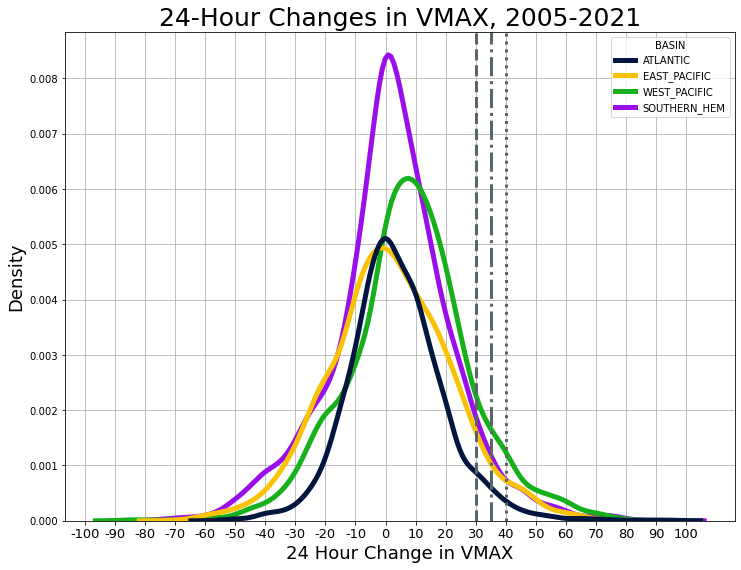

In [48]:
fig1,ax1 = plt.subplots(1,1,figsize=(12,9))
sns.kdeplot(data=diff_train.reset_index(),x='d24_VMAX',hue='BASIN',palette=pal_sel,linewidth=5,ax=ax1)
ax1.axvline(x=30,color='xkcd:slate grey',linestyle='--',linewidth=3)
ax1.axvline(x=35,color='xkcd:slate grey',linestyle='-.',linewidth=3)
ax1.axvline(x=40,color='xkcd:slate grey',linestyle=':',linewidth=3)
#ax1.legend(fontsize=13)
ax1.set_xlabel('24 Hour Change in VMAX',fontsize=18)
ax1.set_xticks(np.arange(-100,101,10))
ax1.set_xticklabels(np.arange(-100,101,10),fontsize=13)
ax1.set_ylabel('Density',fontsize=18)
ax1.grid()
#ax1.legend(fontsize=14)
ax1.set_title('24-Hour Changes in VMAX, 2005-2021',fontsize=25)

In [23]:
diff = SHIPS_predictors.set_index(['BASIN','CASE','TIME']).xs(0,level=2).shift(4)['VMAX'] - SHIPS_predictors.set_index(['BASIN','CASE','TIME']).xs(0,level=2)['VMAX']
diff2 = diff.mask(diff < 40)

In [24]:
diff2.dropna(how='all')

BASIN         CASE   
ATLANTIC      7337.0     50.0
              7365.0     70.0
              7366.0     65.0
              7377.0     95.0
              7378.0     80.0
                         ... 
SOUTHERN_HEM  14513.0    55.0
              14514.0    55.0
              14515.0    40.0
              14673.0    40.0
              14687.0    40.0
Name: VMAX, Length: 1283, dtype: float64

##### Total number of cases per basin, per year

NameError: name 'total_cases' is not defined

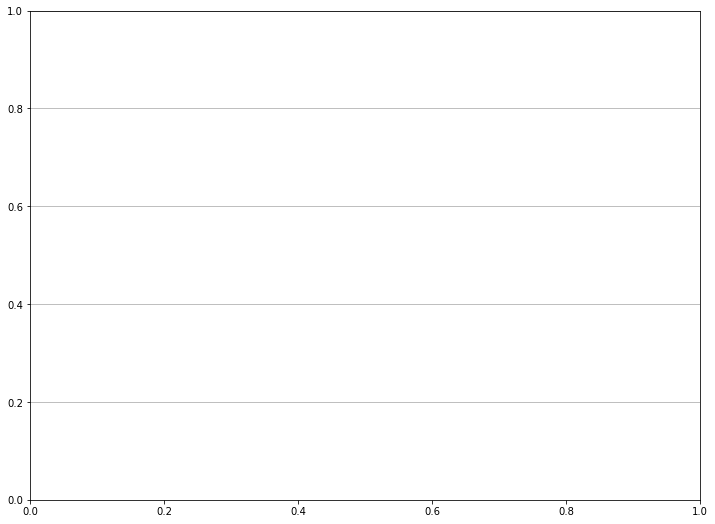

In [12]:
fig1,ax1 = plt.subplots(1,1,figsize=(12,9))
ax1.grid(axis='y',zorder=2)
sns.barplot(data=total_cases.reset_index(),x='DATE_full',y='CASE',hue='BASIN',palette=pal_sel,ax=ax1)
ax1.set_xlabel('Year',fontsize=21)
ax1.set_xticklabels(np.arange(yr_start,yr_end_LOAD+1),fontsize=15,rotation=45)
ax1.set_ylabel('Number of Cases',fontsize=21)
ax1.set_yticklabels([0,1000,2000,3000,4000],fontsize=15)
ax1.legend(fontsize=14,bbox_to_anchor=(0.275,0,1,1))
ax1.set_title('Number of Tropical Cyclone Cases, {yr_start}-{yr_end}'.format(yr_start=yr_start,
                                                                                    yr_end=yr_end_LOAD),fontsize=27)